In [1]:
import os
import re
import glob
import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm import tqdm

In [2]:
fig_folder = 'fig'
os.makedirs(fig_folder, exist_ok=True)

In [3]:
analysis_log_folder  = 'analysis_log'
os.makedirs(analysis_log_folder, exist_ok=True)

In [4]:
sat_log_folder_list = [os.path.join(exp_path, 'dynamic_state_1000ms_for_864000s') for exp_path in os.listdir('./gen_data') if 'sentinel2_isls' in exp_path]
print(sat_log_folder_list)
print("number of gs files", len(sat_log_folder_list))

['sentinel2_isls_none_ground_stations_first_10_algorithm_free_one_only_gs_relays/dynamic_state_1000ms_for_864000s']
number of gs files 1


In [11]:
# build dummy log file
sat_log_folder_list = ['dummy_log_file_' + str(num_gs) + '_a/dynamic_state_1000ms_for_864000s' for num_gs in range(10, 101, 10)]

In [12]:
re_num_gs = r'.*_(\d+)_.*dynamic_state_1000ms_for_864000s'

In [13]:
for sat_log_folder in sat_log_folder_list:
    # get the number of gs
    num_gs = re.findall(re_num_gs, sat_log_folder)[0]
    num_gs = int(num_gs)
    print("num_gs", num_gs)
    # get folder path
    sat_log_folder_path = os.path.join('./gen_data', sat_log_folder)
    # check if 
    if os.path.exists(os.path.join(analysis_log_folder, 'session_list_' + str(num_gs) + '.json')) \
        and os.path.exists(os.path.join(analysis_log_folder, 'active_session_dict_' + str(num_gs) + '.json')) \
        and os.path.exists(os.path.join(analysis_log_folder, 'num_conneted_sat_0_' + str(num_gs) + '.json')) \
        and os.path.exists(os.path.join(analysis_log_folder, 'num_conneted_sat_1_' + str(num_gs) + '.json')):
        print("already processed")
        continue
    # get all the log files
    timestep_filename_list = os.listdir(sat_log_folder_path)
    timestep_filename_list.sort(key=lambda x:int(x.split('.')[0].split('_')[-1]))
    print(timestep_filename_list[:5])
    num_conneted_sat_0 = []
    num_conneted_sat_1 = []
    active_session_dict = {} # {(sid, gid): start_time}
    session_list = [] # {'gid': gid, 'sid': sid, 'start_time': start_time, 'end_time': end_time}
    for timestep_filename in tqdm(timestep_filename_list):
        # get time step
        time_step = int(timestep_filename.split('.')[0].split('_')[-1]) / 1000000 # add /1000000 to get data in ms 
        timestep_file_path = os.path.join(sat_log_folder_path, timestep_filename)
        with open(timestep_file_path, 'r') as load_f:
            timestep_info = json.load(load_f)
        # check all the sg_connection for active sessions
        this_time_active_session_set = set() # set of (sid, gid)
        for sid, gs_list_dict_wrap in timestep_info['sg_connection'].items():
            gs_list = gs_list_dict_wrap['gs_list']
            for gs_pair_info in gs_list:
                active_gid = gs_pair_info['gid']
                this_time_active_session_set.add((sid, active_gid))
        # check if any active session disconnected
        sg_pair_to_del = set()
        for (sid, gid), start_time in active_session_dict.items():
            if (sid, gid) not in this_time_active_session_set:
                session_list.append({
                    'gid': gid,
                    'sid': sid,
                    'start_time': start_time,
                    'end_time': time_step,
                    'duration': time_step - start_time
                })
                sg_pair_to_del.add((sid, gid))
        # remove key-val from active session dict
        for (sid, gid) in sg_pair_to_del:
            del active_session_dict[(sid, gid)]
        # check if create new session
        for (sid, gid) in this_time_active_session_set:
            if (sid, gid) not in active_session_dict:
                active_session_dict[(sid, gid)] = time_step
        # check how many ground stations is connected by each satellite
        num_conneted_sat_0.append(len(timestep_info['sg_connection']['0']['gs_list']))
        num_conneted_sat_1.append(len(timestep_info['sg_connection']['1']['gs_list']))
    # save the session_list
    with open(os.path.join(analysis_log_folder, 'session_list_' + str(num_gs) + '.json'), 'w') as dump_f:
        json.dump(session_list, dump_f, indent=4)
    # save the active_session_dict
    with open(os.path.join(analysis_log_folder, 'active_session_dict_' + str(num_gs) + '.json'), 'w') as dump_f:
        json.dump(active_session_dict, dump_f, indent=4)
    # save num_conneted_sat_0 and num_conneted_sat_1
    with open(os.path.join(analysis_log_folder, 'num_conneted_sat_0_' + str(num_gs) + '.json'), 'w') as dump_f:
        json.dump(num_conneted_sat_0, dump_f, indent=4)
    with open(os.path.join(analysis_log_folder, 'num_conneted_sat_1_' + str(num_gs) + '.json'), 'w') as dump_f:
        json.dump(num_conneted_sat_1, dump_f, indent=4)


num_gs 10
already processed
num_gs 20
already processed
num_gs 30
already processed
num_gs 40
already processed
num_gs 50
already processed
num_gs 60
already processed
num_gs 70
already processed
num_gs 80
already processed
num_gs 90
already processed
num_gs 100
already processed


In [14]:
# combine the overlapped sessions for the same satellite with different ground stations
for sat_log_folder in sat_log_folder_list:
    # get the number of gs
    num_gs = re.findall(re_num_gs, sat_log_folder)[0]
    num_gs = int(num_gs)
    # skip if the file already exists
    if os.path.exists(os.path.join(analysis_log_folder, 'combined_session_list_' + str(num_gs) + '.json')):
        print("already processed")
        continue
    # get session list file
    session_list_file_path = os.path.join(analysis_log_folder, 'session_list_' + str(num_gs) + '.json')
    with open(session_list_file_path, 'r') as load_f:
        session_list = json.load(load_f)
    # combine the overlapped sessions
    sat_combined_session_list_dict = {} # {sid: [session_list]}
    # sort the session list by start time
    session_list.sort(key=lambda x:x['start_time'])
    for session in session_list:
        sid = session['sid']
        if sid not in sat_combined_session_list_dict:
            sat_combined_session_list_dict[sid] = []
        if len(sat_combined_session_list_dict[sid]) == 0:
            sat_combined_session_list_dict[sid].append({
                'gid': [session['gid']],
                'sid': sid,
                'start_time': session['start_time'],
                'end_time': session['end_time'],
                'duration': session['duration']
            })
        else:
            last_session = sat_combined_session_list_dict[sid][-1]
            if session['start_time'] < last_session['end_time']:
                last_session['end_time'] = session['end_time']
                last_session['duration'] = last_session['end_time'] - last_session['start_time']
                last_session['gid'] = list(set(last_session['gid'] + [session['gid']]))
            else:
                sat_combined_session_list_dict[sid].append({
                    'gid': [session['gid']],
                    'sid': sid,
                    'start_time': session['start_time'],
                    'end_time': session['end_time'],
                    'duration': session['duration']
                })
    # combine the session list
    num_gs_combined_session_list = []
    for sid, combined_session_list in sat_combined_session_list_dict.items():
        num_gs_combined_session_list += combined_session_list
    # save the combined session list
    with open(os.path.join(analysis_log_folder, 'combined_session_list_' + str(num_gs) + '.json'), 'w') as dump_f:
        json.dump(num_gs_combined_session_list, dump_f, indent=4)


In [15]:
# compute the total duration of every 24 / 14.31 * 3600 seconds
one_round_time_interval = 24 / 14.31 * 3600 * 1000
print(one_round_time_interval)

6037735.849056604


In [16]:
# load session list for each gs num
for sat_log_folder in sat_log_folder_list:
    # get the number of gs
    num_gs = re.findall(re_num_gs, sat_log_folder)[0]
    num_gs = int(num_gs)
    # # read session list log
    # with open(os.path.join(analysis_log_folder, 'session_list_' + str(num_gs) + '.json'), 'r') as load_f:
    #     session_list = json.load(load_f)
    # read combined session list log
    with open(os.path.join(analysis_log_folder, 'combined_session_list_' + str(num_gs) + '.json'), 'r') as load_f:
        session_list = json.load(load_f)
    # sort session list according to the start time
    session_list = sorted(session_list, key=lambda x:x['start_time'])
    # create round connection time list
    sat0_round_connection_time_list = []
    sat1_round_connection_time_list = []
    # traverse the session list
    this_round_end_time = one_round_time_interval
    this_round_sat0_conn_time_total = 0
    this_round_sat1_conn_time_total = 0

    for session in session_list:
        if session['start_time'] > this_round_end_time:
            print('append new durations at', session['start_time'], 'for', session['sid'], ' and ', session['gid'], 'now the time becomes: ', this_round_end_time)
            sat0_round_connection_time_list.append(this_round_sat0_conn_time_total)
            sat1_round_connection_time_list.append(this_round_sat1_conn_time_total)
            this_round_end_time += one_round_time_interval
            this_round_sat0_conn_time_total = 0
            this_round_sat1_conn_time_total = 0
        if session['sid'] == '0':
            this_round_sat0_conn_time_total += session['duration']
        elif session['sid'] == '1':
            this_round_sat1_conn_time_total += session['duration']
        else:
            raise NotImplementedError('Wrong SID parsed')
    
    sat0_round_connection_time_list = np.array(sat0_round_connection_time_list)
    sat1_round_connection_time_list = np.array(sat1_round_connection_time_list)

    sat0_round_connection_stat = {
        'list': list(sat0_round_connection_time_list),
        'max': np.max(sat0_round_connection_time_list),
        'min': np.min(sat0_round_connection_time_list),
        'mean': np.mean(sat0_round_connection_time_list),
        'std': np.std(sat0_round_connection_time_list)
    }

    sat1_round_connection_stat = {
        'list': list(sat1_round_connection_time_list),
        'max': np.max(sat1_round_connection_time_list),
        'min': np.min(sat1_round_connection_time_list),
        'mean': np.mean(sat1_round_connection_time_list),
        'std': np.std(sat1_round_connection_time_list)
    }

    with open(os.path.join(analysis_log_folder, 'sat0_round_connection_stat_' + str(num_gs) + '.json'), 'w') as dump_f:
        json.dump(sat0_round_connection_stat, dump_f, indent=4)
    with open(os.path.join(analysis_log_folder, 'sat1_round_connection_stat_' + str(num_gs) + '.json'), 'w') as dump_f:
        json.dump(sat1_round_connection_stat, dump_f, indent=4)
    



append new durations at 11412000.0 for 1  and  [8] now the time becomes:  6037735.849056604
append new durations at 14401000.0 for 0  and  [8] now the time becomes:  12075471.698113209
append new durations at 24680000.0 for 0  and  [0] now the time becomes:  18113207.547169812
append new durations at 27458000.0 for 0  and  [3] now the time becomes:  24150943.396226417
append new durations at 30406000.0 for 1  and  [3] now the time becomes:  30188679.245283023
append new durations at 38386000.0 for 0  and  [9] now the time becomes:  36226415.094339624
append new durations at 42472000.0 for 0  and  [1, 4] now the time becomes:  42264150.943396226
append new durations at 51728000.0 for 1  and  [8] now the time becomes:  48301886.79245283
append new durations at 54684000.0 for 0  and  [8] now the time becomes:  54339622.64150943
append new durations at 71737000.0 for 1  and  [0, 7] now the time becomes:  60377358.49056603
append new durations at 72005000.0 for 0  and  [3] now the time beco

In [17]:
# plot num station - average connection time
sat_0_mean_round_connection = []
sat_1_mean_round_connection = []
sat_0_std_round_connection = []
sat_1_std_round_connection = []
num_gs_list = []
# sort sat_log_folder_list by num_gs
sat_log_folder_list.sort(key=lambda x: int(re.findall(re_num_gs, x)[0]))
for sat_log_folder in sat_log_folder_list:
    # get the number of gs
    num_gs = re.findall(re_num_gs, sat_log_folder)[0]
    num_gs = int(num_gs)
    # read satellite round-wise connection duration
    sat0_round_connection_stat_path = os.path.join(analysis_log_folder, 'sat0_round_connection_stat_' + str(num_gs) + '.json')
    sat1_round_connection_stat_path = os.path.join(analysis_log_folder, 'sat1_round_connection_stat_' + str(num_gs) + '.json')
    # load json file
    with open(sat0_round_connection_stat_path, 'r') as load_f:
        sat0_round_connection_stat = json.load(load_f)
    with open(sat1_round_connection_stat_path, 'r') as load_f:
        sat1_round_connection_stat = json.load(load_f)
    # append to list
    sat_0_mean_round_connection.append(sat0_round_connection_stat['mean'])
    sat_1_mean_round_connection.append(sat1_round_connection_stat['mean'])
    sat_0_std_round_connection.append(sat0_round_connection_stat['std'])
    sat_1_std_round_connection.append(sat1_round_connection_stat['std'])
    num_gs_list.append(num_gs)

[ 6.15140845  9.40422535 14.55117371 17.14778555 17.31666667 18.95932401
 19.35431235 21.13811189 22.37948718 23.20874126]
[ 6.13814554  9.46467136 14.59483568 17.25932401 17.33356643 18.96200466
 19.44417249 21.2479021  22.39300699 23.21689977]


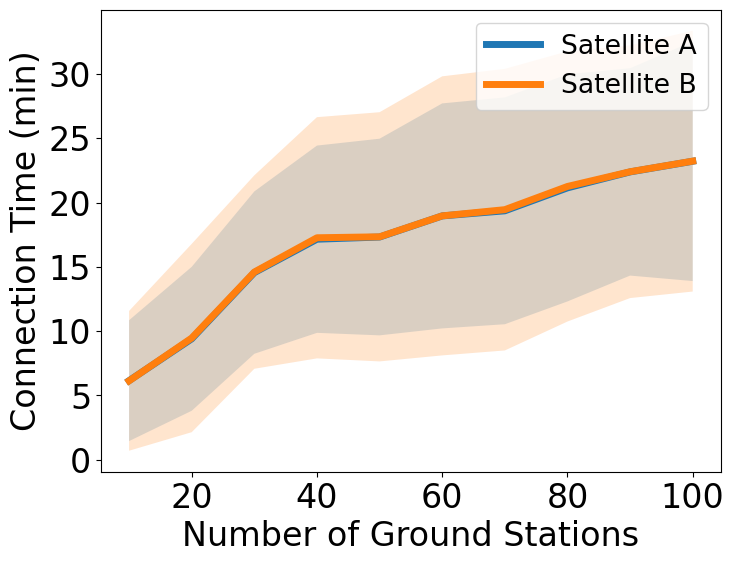

In [18]:
# plot 
fig = plt.figure(figsize=(8,6))

font_size = 24

sat_0_mean_round_connection = np.array(sat_0_mean_round_connection)
sat_1_mean_round_connection = np.array(sat_1_mean_round_connection)
sat_0_std_round_connection = np.array(sat_0_std_round_connection)
sat_1_std_round_connection = np.array(sat_1_std_round_connection)


print(sat_0_mean_round_connection / 60000)
print(sat_1_mean_round_connection / 60000)

plt.plot(num_gs_list, sat_0_mean_round_connection / 60000, label='Satellite A', linewidth=5)
plt.plot(num_gs_list, sat_1_mean_round_connection / 60000, label='Satellite B', linewidth=5)

plt.fill_between(num_gs_list, sat_0_mean_round_connection / 60000 - sat_0_std_round_connection / 60000, sat_0_mean_round_connection / 60000 + sat_0_std_round_connection / 60000, alpha = 0.2)
plt.fill_between(num_gs_list, sat_1_mean_round_connection / 60000 - sat_1_std_round_connection / 60000, sat_1_mean_round_connection / 60000 + sat_1_std_round_connection / 60000, alpha = 0.2)

plt.legend(fontsize=font_size * 0.8)
plt.xlabel('Number of Ground Stations', fontsize=font_size)
plt.ylabel('Connection Time (min)', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.savefig(os.path.join(fig_folder, 'num_gs_sat_conn_duration.pdf'), bbox_inches='tight')
plt.show()